In [4]:
%pip install rdkit


In [5]:
pip install pandas numpy scikit-learn matplotlib torch rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 847.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

[04:47:41] SMILES Parse Error: syntax error while parsing: Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C
[04:47:41] SMILES Parse Error: check for mistakes around position 21:
[04:47:41] Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3
[04:47:41] ~~~~~~~~~~~~~~~~~~~~^
[04:47:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C' for input: 'Cc1cc(ccc1[N+](=O)[Or])C(=O)NCCc2c([nH]c3c2cccc3)C'
[04:47:41] SMILES Parse Error: syntax error while parsing: Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]
[04:47:41] SMILES Parse Error: check for mistakes around position 32:
[04:47:41] Cc2ccccc2)[N+](=O)[Or]
[04:47:41] ~~~~~~~~~~~~~~~~~~~~^
[04:47:41] SMILES Parse Error: Failed parsing SMILES 'Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]' for input: 'Cc1c(cccc1OCc2ccccc2)[N+](=O)[Or]'
[04:47:41] SMILES Parse Error: syntax error while parsing: CC1(OC(=O)C(=Cc2ccc(s2)[N+](=O)[Or])C(=O)O1)C
[04:47:41] SMILES Parse Error: check for mistakes around position 34:
[04:47:41] Cc2ccc(s2)[N

Epoch 100/500, Loss: 0.6577, Accuracy: 0.4840
Epoch 200/500, Loss: 0.5781, Accuracy: 0.5089
Epoch 300/500, Loss: 0.5374, Accuracy: 0.5461
Epoch 400/500, Loss: 0.5301, Accuracy: 0.5443
Epoch 500/500, Loss: 0.5250, Accuracy: 0.5408
LSTM - R^2: 0.64, MSE: 0.51, Accuracy: 0.57


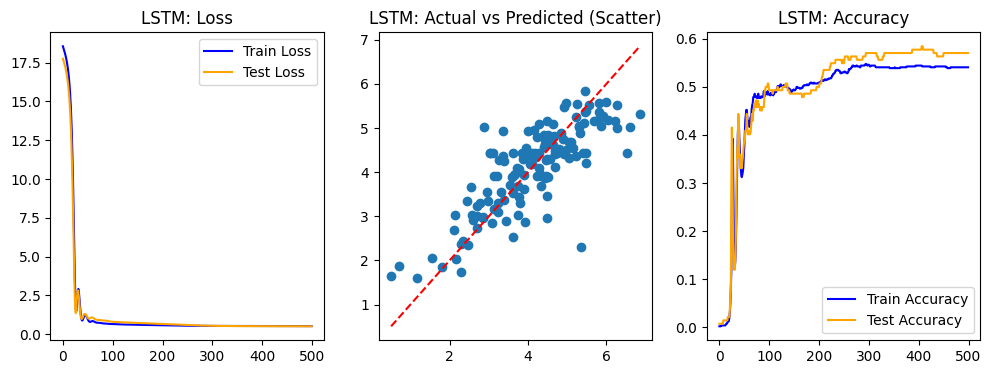

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load the logP_synthetic dataset
data = pd.read_csv('logP_experimental_dataset.csv', header=None, names=['slimp', 'exp'])
# Clean and convert target column to numeric (in case of strings or invalid entries)
data['exp'] = pd.to_numeric(data['exp'], errors='coerce')  # convert invalid entries to NaN
data = data.dropna(subset=['exp'])  # drop rows with NaN in 'exp'


# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)  # Return a zero vector if SMILES is invalid
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)  # LogP of the molecule
    ]
    return descriptors

# Apply descriptor computation to the SMILES column
X = np.array([compute_descriptors(smiles) for smiles in data['slimp']])
y = data['exp'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



# Convert data to PyTorch tensors and reshape for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add time dimension
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 200, num_layers=5, batch_first=True)  # 5 LSTM layers with 200 neurons each
        self.fc = nn.Linear(200, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last time step
        return x

# Initialize LSTM model
input_dim = X_train.shape[1]
lstm_model = LSTMModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 500
accuracy_threshold = 0.5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Compute accuracy during training
    train_accuracy = torch.mean((torch.abs(predictions - y_train_t) < accuracy_threshold).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_preds = lstm_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = torch.mean((torch.abs(test_preds - y_test_t) < accuracy_threshold).float()).item()

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_preds = lstm_model(X_test_t).detach().numpy().flatten()
lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_accuracy = np.mean(np.abs(lstm_preds - y_test) < accuracy_threshold)

# Display performance metrics
print(f"LSTM - R^2: {lstm_r2:.2f}, MSE: {lstm_mse:.2f}, Accuracy: {lstm_accuracy:.2f}")

# Plot results
import matplotlib.pyplot as plt

def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name}: Accuracy")
    plt.legend()

    plt.show()

# Plot results for LSTM
plot_results("LSTM", y_test, lstm_preds, train_losses, test_losses, train_accuracies, test_accuracies)
